# Imports/Device Settings/Utils

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import utils

from PIL import Image

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device} device")
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)


IMAGE_DIM = 48

Using cpu device


In [3]:
ground_truth_images = np.load("training.npy")

##  If you don't have the above dataset:

In [6]:
ground_truth_images = np.zeros((28709, 1, IMAGE_DIM, IMAGE_DIM), np.float32)
utils.create_training_data("../archive/train/", ground_truth_images)

#normalizations step
ground_truth_images = np.multiply(ground_truth_images, 1/255)
np.save("training.npy", ground_truth_images)

image 0
image 1000
image 2000
image 3000
image 4000
image 5000
image 6000
image 7000
image 8000
image 9000
image 10000
image 11000
image 12000
image 13000
image 14000
image 15000
image 16000
image 17000
image 18000
image 19000
image 20000
image 21000
image 22000
image 23000
image 24000
image 25000
image 26000
image 27000
image 28000


## Then back to relevant code:

In [7]:
# Create A.T*y
# CHOOSE SAMPLING RATE HERE

p = IMAGE_DIM**2
n = int(0.5*p)
A = np.random.normal(loc=0, scale=1/n, size=(n, p))

added_noise_images = np.zeros((28709, 1, IMAGE_DIM, IMAGE_DIM), np.float32)

i = 0
for image in ground_truth_images:
    if (i%1000==0):
        print(f"Image {i}")
    x = ground_truth_images[i][0]
    x = np.reshape(x, (2304), 'F')

    added_noise_images[i][0] = np.reshape(np.matmul(A.T, np.matmul(A, x)), (IMAGE_DIM, IMAGE_DIM), 'F')
    i += 1


Image 0
Image 1000
Image 2000
Image 3000
Image 4000
Image 5000
Image 6000
Image 7000
Image 8000
Image 9000
Image 10000
Image 11000
Image 12000
Image 13000
Image 14000
Image 15000
Image 16000
Image 17000
Image 18000
Image 19000
Image 20000
Image 21000
Image 22000
Image 23000
Image 24000
Image 25000
Image 26000
Image 27000
Image 28000


In [8]:
print(np.shape(ground_truth_images))
print(np.shape(added_noise_images))

clean = torch.as_tensor(ground_truth_images, dtype=torch.float32)
noisy = torch.as_tensor(added_noise_images, dtype=torch.float32)

# Set training dictionary

train = {"noisy" : noisy[ : 25000],
        "clean" : clean[ : 25000]}

# Set validation dictionary
validation = {"noisy" : noisy[25000 : ],
        "clean" : clean[25000 : ]}

(28709, 1, 48, 48)
(28709, 1, 48, 48)


## Then back to relevant calculations:

In [9]:
# A priori PSNR calculation
test_number = len(train["noisy"])
print(f"# of test images: {test_number}")

ante_psnr = utils.avg_psnr(300, train["noisy"], train["clean"])
print(f"Avg. PSNR: {round(ante_psnr, 2)}")

# of test images: 25000
Avg. PSNR: 4.33


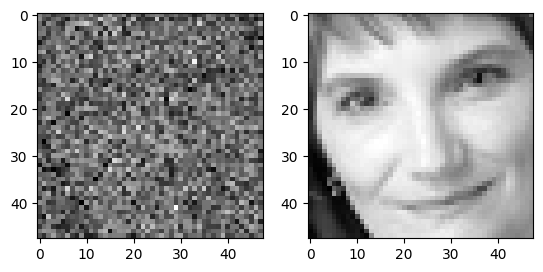

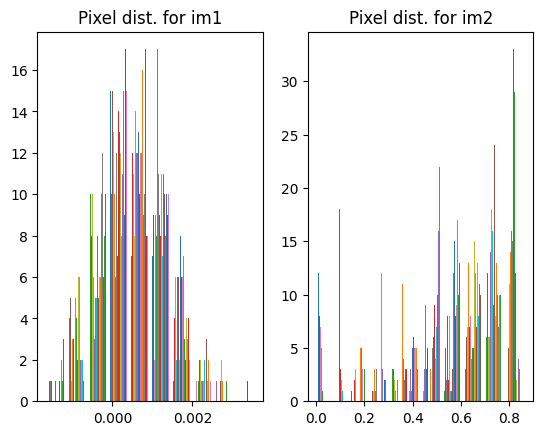

In [12]:
# Optional - compare noisy vs. clean image
sample_no = 0
im1 = utils.detach(noisy[sample_no][0])
im2 = utils.detach(clean[sample_no][0])
utils.show_images(im1, im2)

# Optional - test pixel distributions
utils.show_images_hist(im1, im2)

# Proof of inverse problem setup

In [ ]:
temp = ground_truth_images[0][0]
column1 = temp[0:10, 0]
print(column1)

columns = np.reshape(temp, (2304), 'F')
print(columns[0:10])

#temp = np.rot90(np.flip(temp, 1), 1)
#temp = np.reshape(temp, (48*48))
#print(temp[0:10])

In [ ]:
p = len(temp)
n = int(p/2)
print(p, n)

A = np.random.normal(loc=0, scale=1/n, size=(n, p))

y = np.matmul(A, temp)

Ay = np.matmul(A.T, y)

Ay = np.reshape(Ay, (48, 48), 'F')

plt.imshow(Ay, cmap='gray')

# U-net architecture

In [13]:
# Establish neural network model

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.actv1 = nn.ReLU()

    def forward(self, x):
        x = self.actv1(self.conv1(x))
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        #1 if batched, 0 if unbatched
        self.cat_dim = 1

        self.conv1_1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv1_2 = ConvBlock(in_channels=64, out_channels=64)

        self.maxPool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2_1 = ConvBlock(in_channels=64, out_channels=128)
        self.conv2_2 = ConvBlock(in_channels=128, out_channels=128)

        self.convTranspose1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)

        #DONT FORGET TO ADD CONCATENATION CHANNELS
        self.conv3_1 = ConvBlock(in_channels=128, out_channels=64)
        self.conv3_2 = ConvBlock(in_channels=64, out_channels=1)

    def forward(self, x):
        x = self.conv1_2(self.conv1_1(x))

        skip_connect = x

        x = self.maxPool1(x)

        x = self.conv2_2(self.conv2_1(x))

        x = self.convTranspose1(x)

        x = torch.cat([skip_connect, x], self.cat_dim)

        x = self.conv3_2(self.conv3_1(x))

        return x

unet = UNet()
unet = unet.to(device)
unet.train()

UNet(
  (conv1_1): ConvBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (actv1): ReLU()
  )
  (conv1_2): ConvBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (actv1): ReLU()
  )
  (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (actv1): ReLU()
  )
  (conv2_2): ConvBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (actv1): ReLU()
  )
  (convTranspose1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv3_1): ConvBlock(
    (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (actv1): ReLU()
  )
  (conv3_2): ConvBlock(
    (conv1): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (actv1): ReLU()
  )
)

# Optional Tests

In [14]:
# OPTIONAL
# Testing input/output sizes
input = torch.randn(2, 1, IMAGE_DIM, IMAGE_DIM)
print("Input: ", np.shape(input))

output1 = unet(input)
print("UNet Output: ", np.shape(output1))

Input:  torch.Size([2, 1, 48, 48])
UNet Output:  torch.Size([2, 1, 48, 48])


# Training the Model

### Set hyperparameters

In [15]:
epochs = 5
batch_size = 20
lr = 1e-5
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)

In [16]:
# Training
loss_record = utils.train(
    x=train["noisy"],
    y=train["clean"],
    neural_network=unet,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=lr,
    loss_function=loss_fn,
    optimizer=optimizer
)

Starting training...
tensor(0.3782, grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

# Loss graph

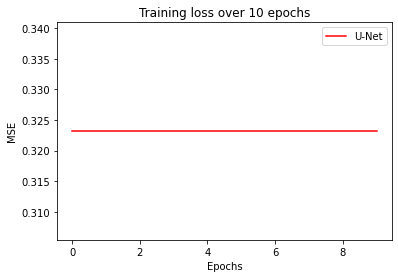

In [12]:
epoch_record = np.arange(0, len(loss_record), 1)
plt.plot(epoch_record, loss_record, c="red", label="U-Net")
plt.legend(loc="upper right")
plt.title(f"Training loss over {epochs} epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

# Tests/PSNR Calculations

In [ ]:
unet.eval()

In [ ]:
# Choose between [0, 19]
sample_number = 1
test_size = 20

# Test visual recovery results
with torch.no_grad():
    unet_pred = utils.detach(unet(validation["noisy"][0:test_size]))